# Process "API" with event sub-processes

This is an example, how non-interrupting event subprocess with message start event, could be used to communicate and interact with process. 

In [1]:
from IPython.display import display
from requests import get, post

## Example process

At first, we need to design a process with a such event sub-process:

In [2]:
bpmn = open("example-messages.bpmn").read()

Then we define some helpers to render the state of the process:

In [3]:
from IPython.display import display
from pandas import DataFrame as df
import json

config = {
    "style": {
        "height": "400px"
    },
    "zoom": 1.2
}
render = lambda update={}: display({
    "application/bpmn+xml": bpmn,
    "application/bpmn+json": json.dumps(config | update)
}, raw=True)
variables = lambda d={}: [{
    "name": k,
    "type": v["type"],
    "value": v["value"],
} for k,v in d.items()]

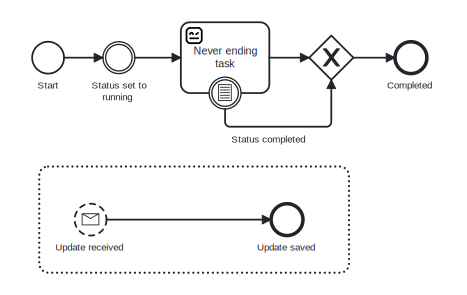

In [4]:
render()

## Deploying a process

Next, we need to deploy it.

In [5]:
base_url = "http://localhost:8080/engine-rest"
definition_key = "example-event-sub-process"

In [6]:
definition_id = list(post(f"{base_url}/deployment/create", files={
    "deployment-name": "Example",
    "deploy-changed-only": False,
    "deployment-source": "notebook",
    "bpmn": bpmn
}).json()["deployedProcessDefinitions"].values())[0]["id"]

## Starting a new instance

Once it's deployed, we are able to start an instance of it:

In [7]:
instance_id = post(f"{base_url}/process-definition/{definition_id}/start", headers={"content-type": "application/json"}).json()["id"]

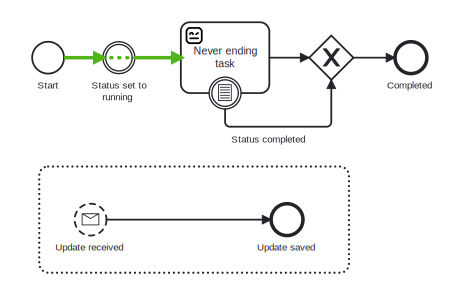

In [8]:
render(dict(activities=get(f"{base_url}/history/activity-instance", params={"processInstanceId": instance_id}).json()))

And, as we see, the process starts without variables:

In [9]:
df(variables(get(f"{base_url}/process-instance/{instance_id}/variables").json()))

,name,type,value
0,status,String,running


## Setting and querying process variables

In [10]:
import base64
message = {
    "messageName": "UpdateExampleMessage",
    "processInstanceId": instance_id,
    "processVariables": {
        "status": {
            "type": "String",
            "value": "still-running"
        },
        "message.txt": {
            "type": "File",
            "value": base64.b64encode("Hello World".encode("utf-8")).decode("UTF-8"),
            "valueInfo": { "filename": "message.txt", "mimetype": "text/plain", "encoding": "UTF-8" }
        }
    },
    "resultEnabled": True,
    "variablesInResultEnabled": True
}

In [11]:
df(variables(post(f"{base_url}/message", json=message).json()[0]["variables"]))

,name,type,value
0,message.txt,File,None
1,status,String,still-running


In [12]:
get(f"{base_url}/process-instance/{instance_id}/variables/message.txt/data").text

'Hello World'

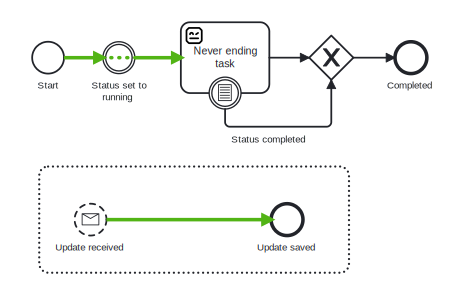

In [13]:
render(dict(activities=get(f"{base_url}/history/activity-instance", params={"processInstanceId": instance_id}).json()))

## Triggering conditional boundary events

In [14]:
message = {
    "messageName": "UpdateExampleMessage",
    "processInstanceId": instance_id,
    "processVariables": {
        "status": {
            "type": "String",
            "value": "completed"
        }
    },
    "resultEnabled": True,
    "variablesInResultEnabled": True
}

In [15]:
df(variables(post(f"{base_url}/message", json=message).json()[0]["variables"]))

,name,type,value
0,message.txt,File,None
1,status,String,completed


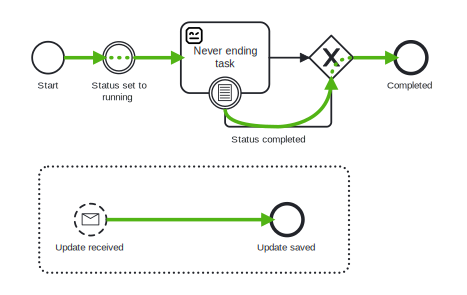

In [16]:
render(dict(activities=get(f"{base_url}/history/activity-instance", params={"processInstanceId": instance_id}).json()))